In [1]:
import numpy as np
import utils as ut
import pandas as pd 
from sklearn import tree as skt
from sklearn import preprocessing as skp 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
X, Y = ut.read_data('data/device_classify_1.csv', x_cols=4)

X_labels = ["DeviceID","PeerCount","DataPerConn","Hour"]
Y_labels = "DevType"
# It is a good idea to print a few numbers to validate that data has been read correctly 

print(X[0:10])
print(Y[0:10])

[[ 0.    0.    9.   30.52]
 [ 1.    0.    2.    1.08]
 [ 2.    0.    7.   38.23]
 [ 3.    0.    6.   33.58]
 [ 5.    0.    9.   33.39]
 [ 6.    0.    1.    2.01]
 [ 7.    0.    9.   38.25]
 [ 8.    0.    1.    2.73]
 [ 9.    0.    8.   36.94]
 [10.    0.    2.    1.38]]
[nan nan nan nan nan nan nan nan nan nan]


In [3]:
# So, we see that numpy is not that good at reading a column which is a text label
# Not surprising, since it is intended to manipulate numeric arrays. 
# Let us switch to use pandas -- which does not restrict us to numeric values 

In [4]:
df = pd.read_csv('data/device_classify_1.csv')
df.head()

,DeviceID,Hour,PeerCount,DataPerConn,DevType
0,0,0,9,30.52,Video
1,1,0,2,1.08,Thermostat
2,2,0,7,38.23,Video
3,3,0,6,33.58,Video
4,5,0,9,33.39,Video


In [5]:
# It is a good idea to plot the data to see what it contains 
# Let us plot the points corresponding to different types of devices 
# We will plot with PeerCount on X axis, DataPerConn on Y axis and DevType to specify color, 

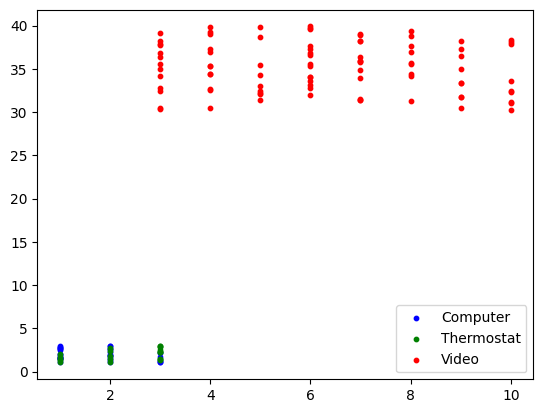

In [6]:
ut.plot_df(df,'PeerCount', 'DataPerConn', 'DevType')

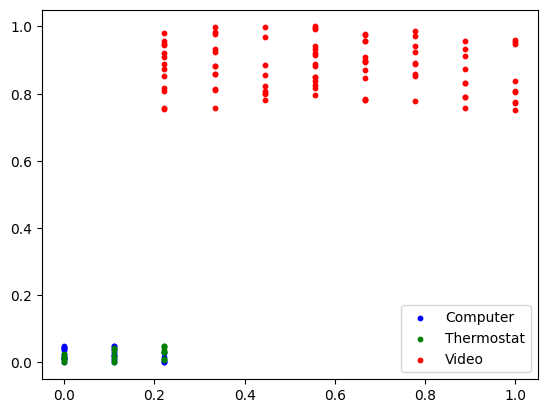

In [7]:
# It looks like video is very different, but computers and thermostats are similar
# Let us scale things down to a unit interval and then plot things again 

scaler = skp.MinMaxScaler()
X = df[['PeerCount','DataPerConn']].to_numpy()
Y = df['DevType'].to_numpy()
scaled_X = scaler.fit_transform(X)
scaled_df=pd.DataFrame({'PeerCount':scaled_X[:,0], 'DataPerConn':scaled_X[:,1], 'DevType':Y})
ut.plot_df(scaled_df,'PeerCount', 'DataPerConn', 'DevType')

In [8]:
# The scaled image and the unscaled image is identical except for the axes. 
# Let us train a decision tree classifier and see how well it performs. 
# We will define a pipeline like we did before. 

def create_pipeline(classifier): 
    myfunctions = [('PreProcess', skp.MinMaxScaler()), ('Classifier', classifier )]
    pipeline = Pipeline(myfunctions)
    return pipeline

pipeline = create_pipeline(skt.DecisionTreeClassifier())

X = df[['PeerCount','DataPerConn']].to_numpy()
Y = df['DevType'].to_numpy()
pipeline.fit(X,Y)

# Let us check how well this pipeline will predict some classes. 
target_values = [[5, 40],[3,16],[2,50]]
pipeline.predict(target_values)

array(['Video', 'Thermostat', 'Video'], dtype=object)

In [9]:
# Assess the accuracy of the pipeline on the training data. 

predictions = pipeline.predict(X)

from sklearn import metrics as skm 
print(f'Accuracy Score is: {skm.accuracy_score(Y, predictions)}')

Accuracy Score is: 1.0


In [10]:
#It is not unusual for accuracy metrics to be high on data that is trained for. 
#Let us split data into two portions and then check for performance metrics

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) 

In [11]:
# Let us examine various accuracy metrics 
def print_scores(actuals, predictions):
    print(f'Accuracy Score is: {skm.accuracy_score(actuals, predictions):.2f}')
    print(f'Balanced Accuracy Score is: {skm.balanced_accuracy_score(actuals, predictions):.2f}')
    print(f'Precision is: {skm.precision_score(actuals, predictions, average="micro"):.2f}')
    print(f'Recall is: {skm.recall_score(actuals, predictions, average="micro"):.2f}')
    print(f'F1 Score is: {skm.f1_score(actuals, predictions, average="micro"):.2f}')


# A convenient routine to check a specific classifier 
def check_classifier(classifier, print_cm=False):
    pipe = create_pipeline(classifier)
    pipe.fit(X_train, Y_train)
    predictions = pipe.predict(X_test)
    print_scores(Y_test, predictions)
    if print_cm:
        skm.ConfusionMatrixDisplay.from_predictions(Y_test, predictions, normalize='true')

In [12]:
check_classifier(skt.DecisionTreeClassifier())

Accuracy Score is: 0.83
Balanced Accuracy Score is: 0.69
Precision is: 0.83
Recall is: 0.83
F1 Score is: 0.83


Accuracy Score is: 0.85
Balanced Accuracy Score is: 0.73
Precision is: 0.85
Recall is: 0.85
F1 Score is: 0.85


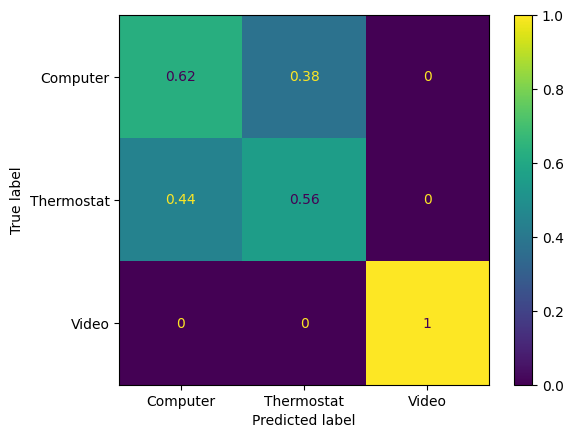

In [13]:
check_classifier(skt.DecisionTreeClassifier(),True)

In [14]:
# Since all models are statistical, we can't rely on a single run and a single partition
# A better approach is to use K-fold cross validation. 
# It it, data is split K ways, and K runs are made using one of the splits as test and others as training
# The cross_val_score returns all the scores from there, and we will just take the average 

def check_classifier_cv(classifier, X, Y, cv):
    pipe = create_pipeline(classifier)
    score = cross_val_score(pipe, X, Y, cv=cv)
    return np.mean(score)

In [15]:
for cv in [5, 8, 10]:
    print(f'Cross Validation Score: {check_classifier_cv(skt.DecisionTreeClassifier(), X, Y, cv):.2f}')

Cross Validation Score: 0.86
Cross Validation Score: 0.86
Cross Validation Score: 0.86
